In [ ]:
ARIMA PREDICATION

In [1]:
import pandas as pd

df = pd.read_csv("google_5yr_one.csv", index_col='Date', parse_dates=True)


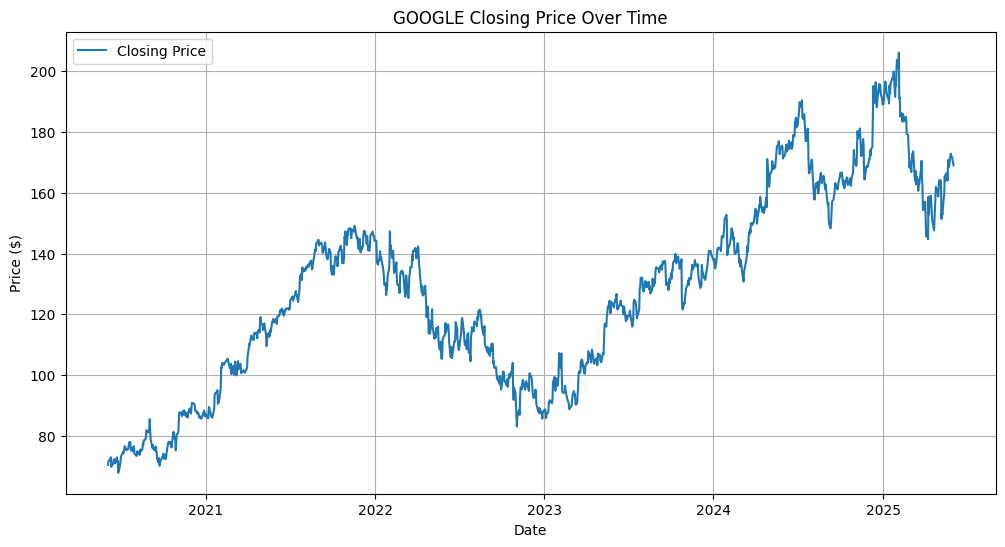

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price')
plt.title("GOOGLE Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from statsmodels.tsa.stattools import adfuller
#Stationarity
# Perform Augmented Dickey-Fuller test
result = adfuller(df['Close'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.4830980468914803
p-value: 0.5418553104422589


In [12]:
df['Close_diff'] = df['Close'] - df['Close'].shift(1)
df['Close_diff'].dropna(inplace=True)

# Re-check stationarity
result_diff = adfuller(df['Close_diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -19.799895710452255
p-value (Differenced): 0.0


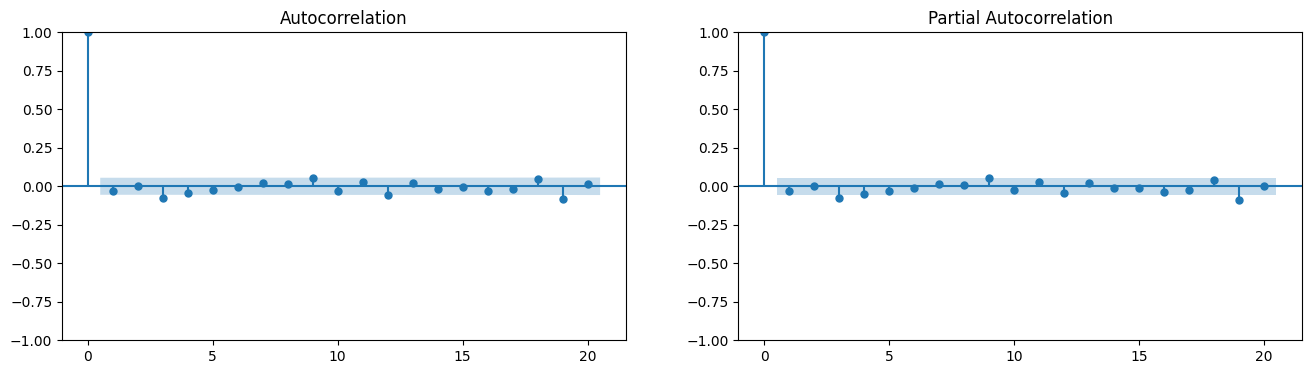

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['Close_diff'].dropna(), lags=20, ax=axes[0])
plot_pacf(df['Close_diff'].dropna(), lags=20, ax=axes[1])
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Define the model
model = ARIMA(df['Close'], order=(1, 1, 1))  # Replace with your chosen p, d, q
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1256
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2941.954
Date:                Fri, 06 Jun 2025   AIC                           5889.908
Time:                        16:19:56   BIC                           5905.313
Sample:                             0   HQIC                          5895.698
                               - 1256                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5978      0.448     -1.336      0.182      -1.475       0.279
ma.L1          0.5684      0.457      1.245      0.213      -0.326       1.463
sigma2         6.3629      0.141     45.162      0.0

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and 

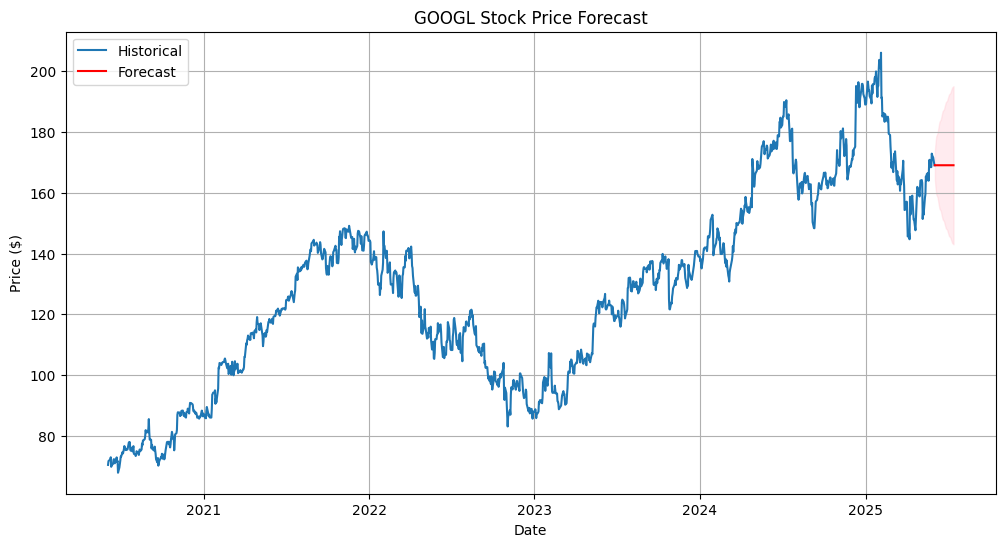

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load your dataset
df = pd.read_csv("google_5yr_one.csv", parse_dates=['Date'], index_col='Date')

# --- Robust Cleaning of 'Close' column ---
df['Close'] = df['Close'].astype(str)
df['Close'] = df['Close'].str.replace(r'[^\d.]', '', regex=True)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
# --- End of Cleaning for ARIMA input ---


# Assign a frequency to the datetime index *after* initial cleaning
df = df.asfreq('B')  # 'B' stands for business day frequency

# Handle missing values that may arise due to frequency assignment or initial cleaning
# Use the recommended ffill() and bfill() methods
df['Close'] = df['Close'].ffill() # Forward fill any NaNs
df['Close'] = df['Close'].bfill() # Backward fill any remaining NaNs (e.g., at the very start)

# Before fitting, ensure no NaNs remain in the 'Close' column
if df['Close'].isnull().any():
    print("Warning: NaNs still present in 'Close' column after cleaning and interpolation.")


# Fit the ARIMA model
if not df['Close'].empty:
    model = ARIMA(df['Close'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast the next 30 days
    forecast_steps = 30
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_df = forecast.summary_frame()

    # Generate future dates for the forecast
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

    # Assign the future dates to the forecast DataFrame
    forecast_df.index = future_dates

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Historical')
    plt.plot(forecast_df['mean'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
    plt.title("GOOGL Stock Price Forecast")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Cannot fit ARIMA model: 'Close' column is empty or contains only NaNs after processing.")

In [22]:
# Save forecast to CSV
forecast_df.to_csv("googl_forecast.csv")


In [ ]:
COMBINING THE RESULTS 

In [23]:
# Load previous processed data
df_returns_vol = pd.read_csv("returns_volatility_output.csv", index_col='Date', parse_dates=True)

# Merge with forecast data
combined_df = df_returns_vol.copy()
combined_df = combined_df.merge(forecast_df[['mean']], left_index=True, right_index=True, how='outer')
combined_df.rename(columns={'mean': 'Forecasted Close'}, inplace=True)

# Save the combined data
combined_df.to_csv("combined_final_data.csv")
